In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from umap_batch import UMAP
from umap_batch import re_pairdis
from umap.utils import fast_knn_indices
from scipy.sparse import csr_matrix

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model_refine
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## CFRM

In [30]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# make scATAC and scRNA to the same scale
A = utils.preprocess(A, modality = "interaction")
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
K = 8
Ns = [K] * 2
N_feat = K
interval = 100
T = 4000
lr = 1e-2

start_time = time.time()
# didn't use the interaction matrix
model1 = model_refine.cfrm_new2(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()

print("running time: " + str(end_time - start_time))

Input sanity check...
Finished.
Epoch 100, Validating Loss: -109.6273
	 loss 1: 89.30493
	 loss 2: 0.00000
	 loss 3: -99.99992
	 loss 4: -98.93228
	 loss 5: 0.00000
Epoch 200, Validating Loss: -110.8900
	 loss 1: 87.98093
	 loss 2: 0.00000
	 loss 3: -99.99631
	 loss 4: -98.87466
	 loss 5: 0.00000
Epoch 300, Validating Loss: -113.1333
	 loss 1: 85.69614
	 loss 2: 0.00000
	 loss 3: -99.99954
	 loss 4: -98.82993
	 loss 5: 0.00000
Epoch 400, Validating Loss: -113.8771
	 loss 1: 85.01906
	 loss 2: 0.00000
	 loss 3: -99.99957
	 loss 4: -98.89661
	 loss 5: 0.00000
Epoch 500, Validating Loss: -114.2109
	 loss 1: 84.60194
	 loss 2: 0.00000
	 loss 3: -99.99951
	 loss 4: -98.81329
	 loss 5: 0.00000
Epoch 600, Validating Loss: -114.3789
	 loss 1: 84.44118
	 loss 2: 0.00000
	 loss 3: -99.99934
	 loss 4: -98.82070
	 loss 5: 0.00000
Epoch 700, Validating Loss: -114.4065
	 loss 1: 84.38322
	 loss 2: 0.00000
	 loss 3: -99.99962
	 loss 4: -98.79008
	 loss 5: 0.00000
Epoch 800, Validating Loss: -114.4607

In [43]:
# check the scaling of A_assos for scATAC over scRNA
scale_A_assos = torch.median(model1.A_assos[1]/(model1.A_assos[0] + 1e-6))
# check the scaling of C_feats for scATAC over scRNA
scale_C_feats = torch.median((model1.As["rna_atac"] @ model1.softmax(model1.C_feats[1]))/model1.softmax(model1.C_feats[0]))
# check the scaling of original count
scale_orig_counts = torch.median(model1.Xs["atac"][1] @ model1.As["rna_atac"].T)/torch.median(model1.Xs["rna"][0])
print("scaling of A_assos (ATAC/RNA): " + str(scale_A_assos.item()))
print("scaling of C_feats (ATAC/RNA): " + str(scale_C_feats.item()))
print("scaling of original count (ATAC/RNA): " + str(scale_orig_counts.item()))


scaling of A_assos (ATAC/RNA): 0.6168370246887207
scaling of C_feats (ATAC/RNA): 0.969065248966217
scaling of original count (ATAC/RNA): 5.852142333984375


In [47]:
import importlib 
importlib.reload(model_refine)

<module 'model_refine' from '../src/model_refine.py'>

In [50]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.8, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

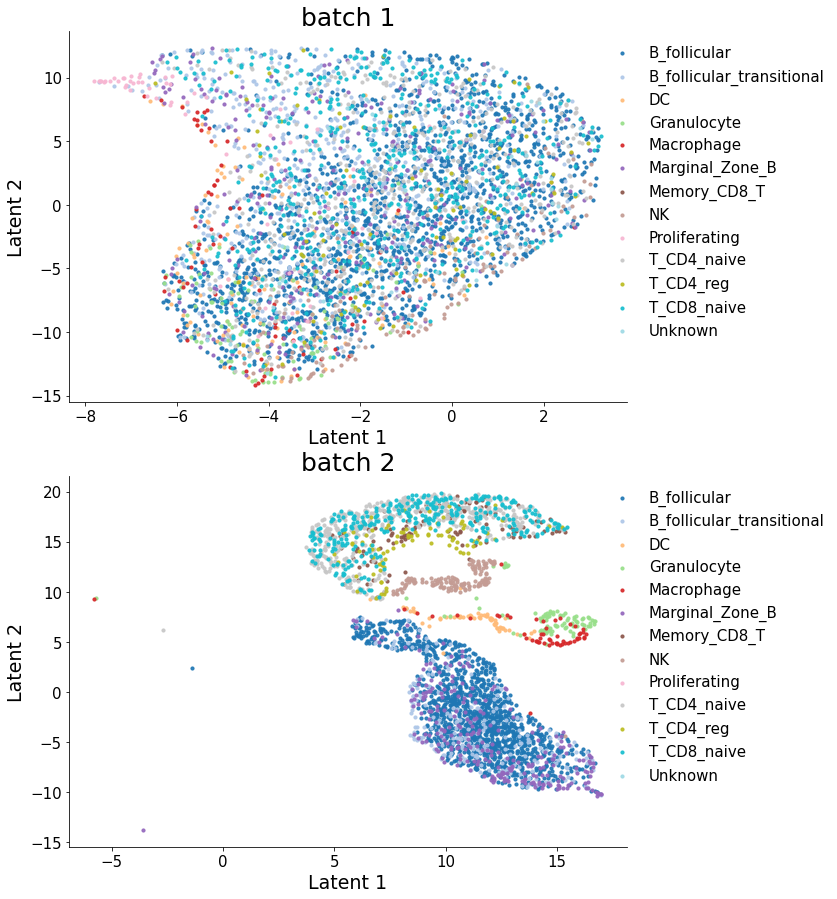

In [51]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")


../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


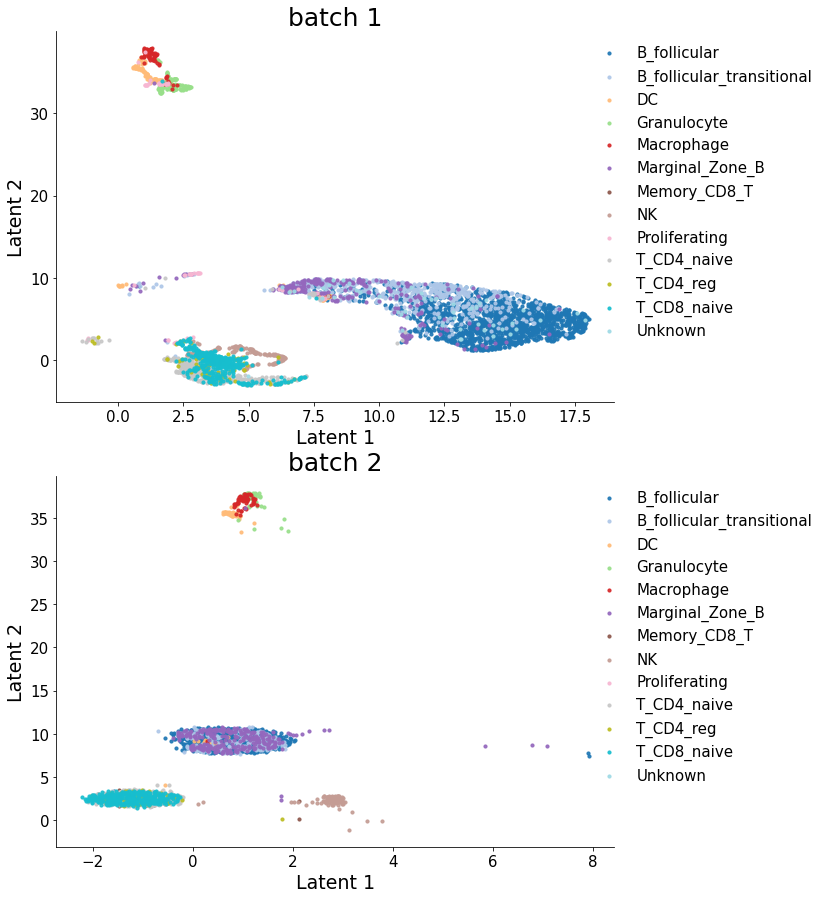

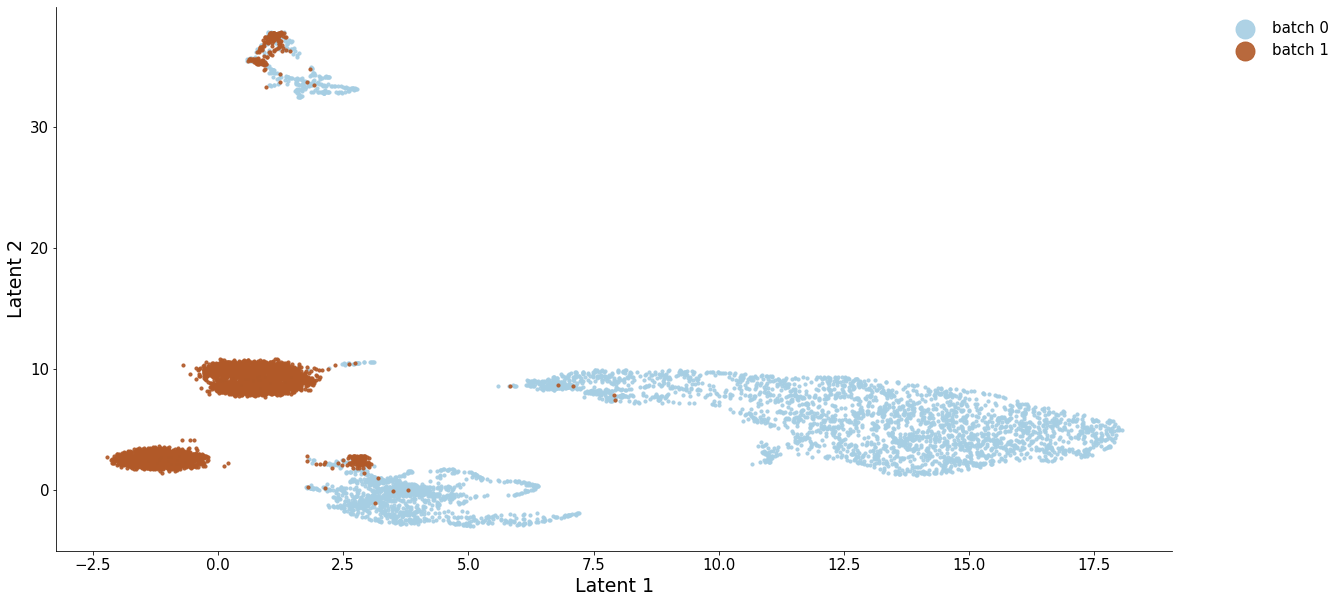

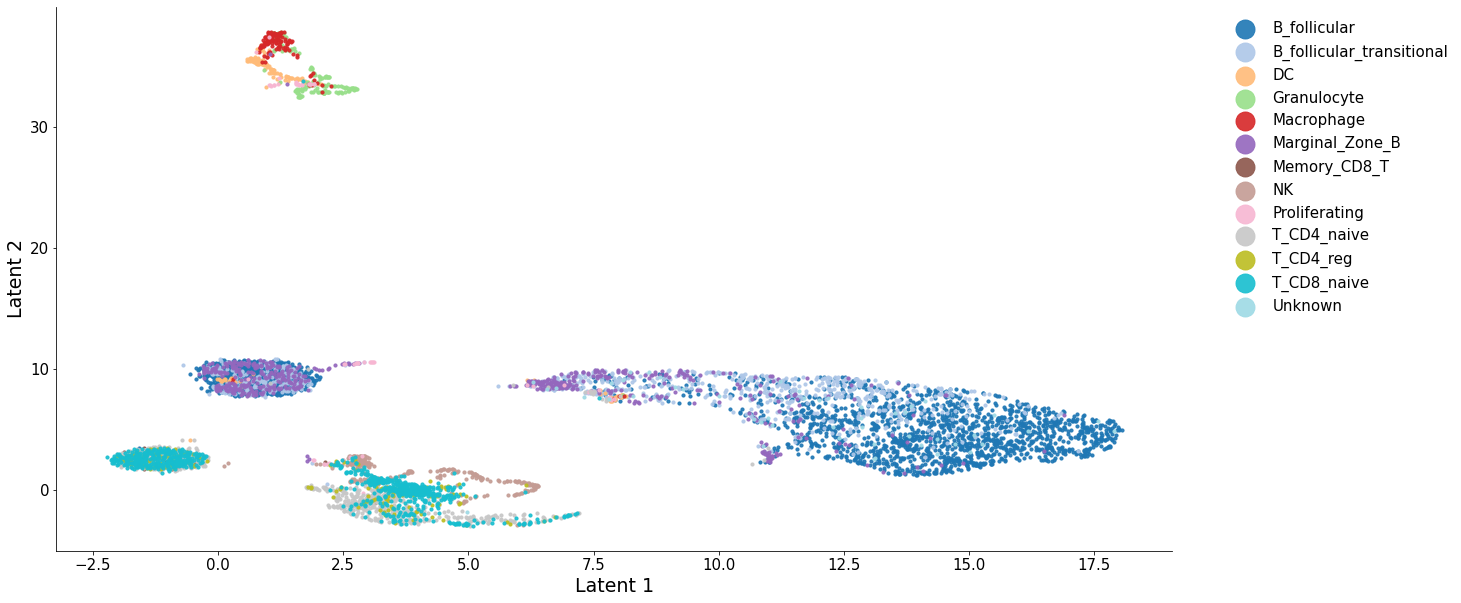

In [31]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, 
                    start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p)
p += p.T - np.diag(p.diagonal())
np.fill_diagonal(p, 0)
s_pair_dist = csr_matrix(p)

# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 12

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)


knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1],
                                 b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)



## Transform scATAC-Seq into scRNA-Seq

In [63]:
# read in dataset, the result is not good, probably because we need to fix the C_gene and A_gene
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# make scATAC and scRNA to the same scale
A = utils.preprocess(A, modality = "interaction")

counts_rnas[1] = counts_atacs[1] @ A.T
counts = {"rna":counts_rnas}

interacts = None

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

counts["feats_name"] = {"rna": genes}



In [4]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
K = 20
Ns = [K] * 2
N_feat = Ns[0]
interval = 100
T = 6000
lr = 1e-2
# # fix Cg and Ag

model1 = model_refine.cfrm_new2(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)

Input sanity check...
Finished.
Epoch 100, Validating Loss: 54.6715
	 loss 1: 54.67153
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: 54.3353
	 loss 1: 54.33527
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: 52.7090
	 loss 1: 52.70903
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: 51.9889
	 loss 1: 51.98886
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: 51.4603
	 loss 1: 51.46031
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: 51.1212
	 loss 1: 51.12120
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: 50.9161
	 loss 1: 50.91613
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: 50.7977
	 loss 1: 50.79766
	 loss 2: 0.00000
	 loss

In [13]:
# not fixing Cg and Ag, good when batch effect is large
# read in dataset, the result is not good, probably because we need to fix the C_gene and A_gene
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# make scATAC and scRNA to the same scale
A = utils.preprocess(A, modality = "interaction")

counts_atacs[1] = counts_atacs[1] @ A.T
counts = {"rna":counts_rnas, "atac":counts_atacs}

interacts = {"rna_atac": torch.eye(counts_rnas[0].shape[1])}

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

counts["feats_name"] = {"rna": genes, "atac": genes}

#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
K = 20
Ns = [K] * 2
N_feat = Ns[0]
interval = 100
T = 6000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model_refine.cfrm_new2(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

In [60]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)


KeyError: 0

../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


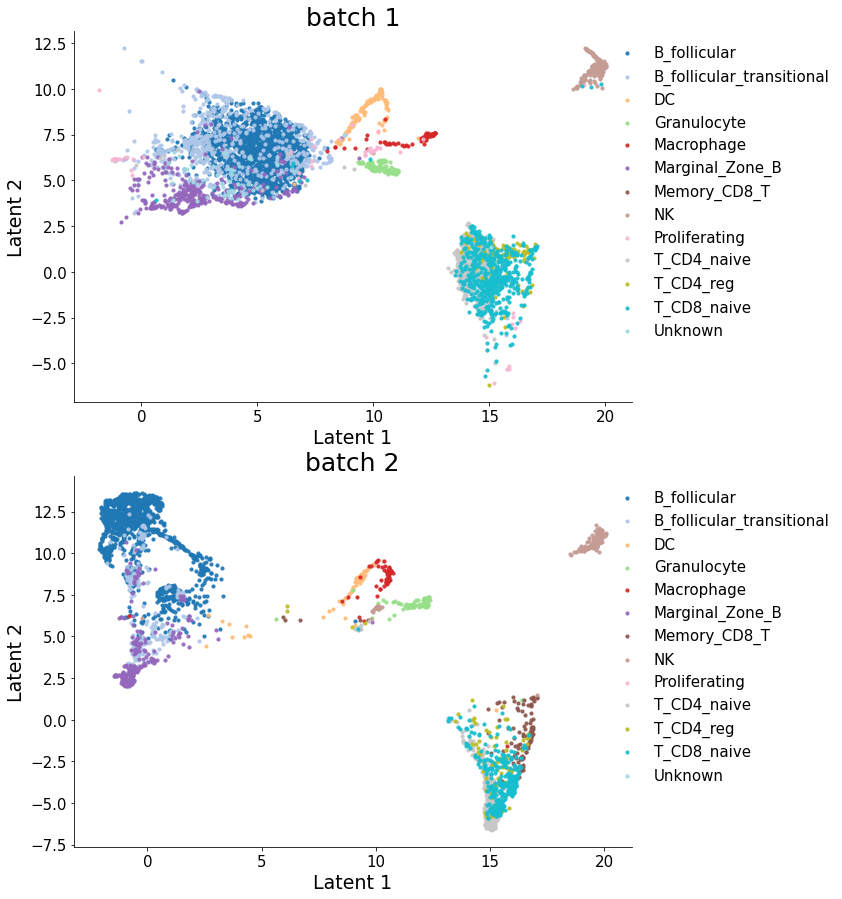

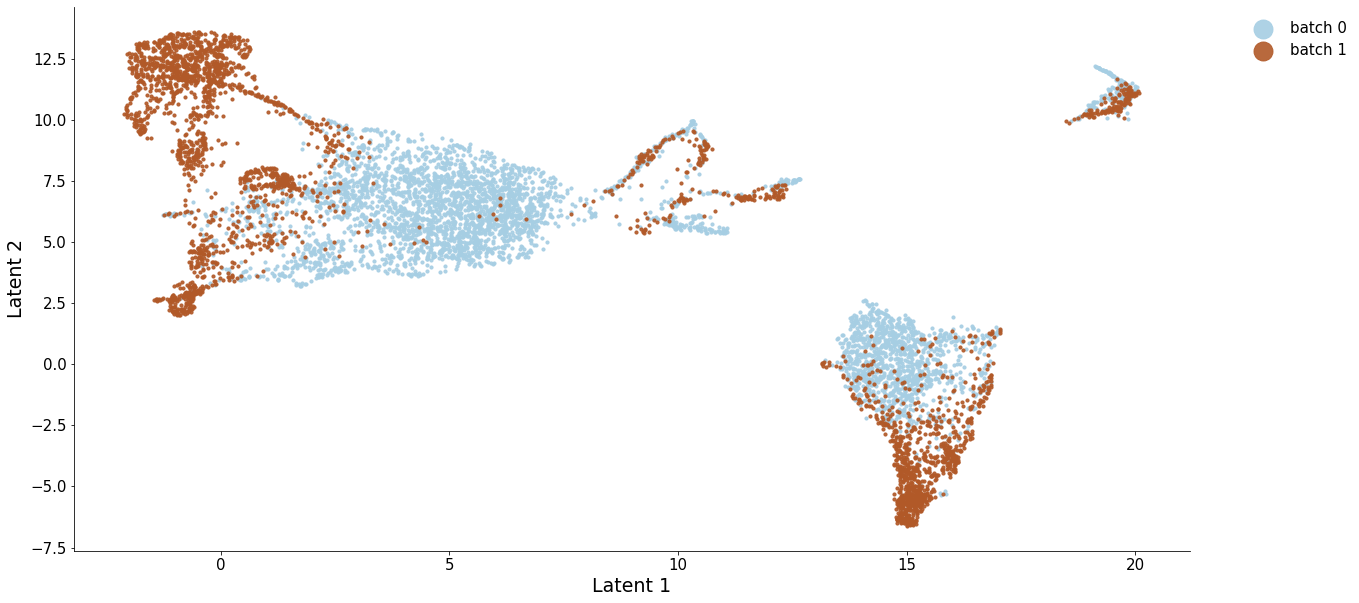

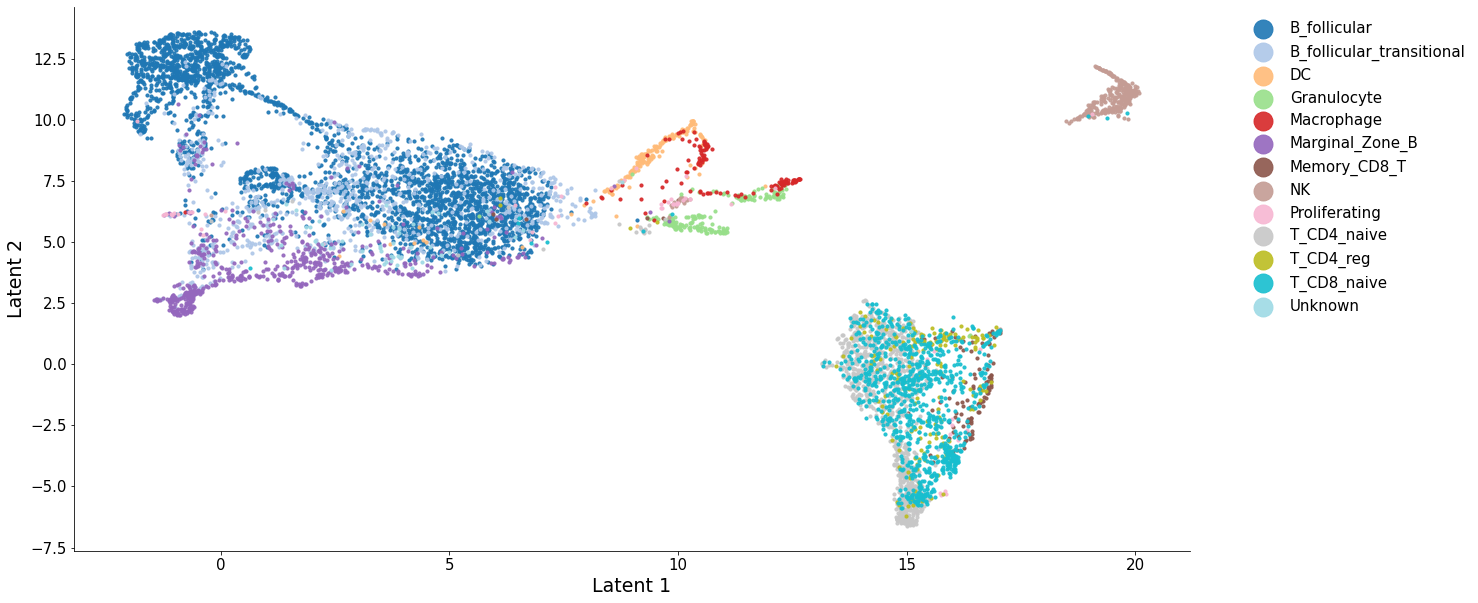

In [44]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, 
                    start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p)
p += p.T - np.diag(p.diagonal())
np.fill_diagonal(p, 0)
s_pair_dist = csr_matrix(p)

# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 12

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)


knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1],
                                 b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)



In [29]:
# check the scaling of A_assos for scATAC over scRNA
scale_A_assos = torch.median(model1.A_assos[1]/(model1.A_assos[0] + 1e-6))
# check the scaling of C_feats for scATAC over scRNA
scale_C_feats = torch.median((model1.As["rna_atac"] @ model1.softmax(model1.C_feats[1]))/model1.softmax(model1.C_feats[0]))
# check the scaling of original count
scale_orig_counts = torch.median(model1.Xs["atac"][1] @ model1.As["rna_atac"].T)/torch.median(model1.Xs["rna"][0])
print("scaling of A_assos (ATAC/RNA): " + str(scale_A_assos.item()))
print("scaling of C_feats (ATAC/RNA): " + str(scale_C_feats.item()))
print("scaling of original count (ATAC/RNA): " + str(scale_orig_counts.item()))


scaling of A_assos (ATAC/RNA): 1.7764716148376465
scaling of C_feats (ATAC/RNA): 1.000768780708313
scaling of original count (ATAC/RNA): 5.852142333984375


## New model
### Transform into scRNA-Seq

In [2]:
import importlib
importlib.reload(model_refine)

<module 'model_refine' from '../src/model_refine.py'>

In [61]:
# read in dataset, the result is not good, probably because we need to fix the C_gene and A_gene
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())

# if one gene is controlled by more regions, the effect of each regions is smaller
# scATAC-Seq should have library size issue?
# A = utils.preprocess(A, modality = "interaction")
# counts_rnas[1] = counts_atacs[1] @ A.T

# make scATAC2RNA and scRNA to the same scale, preprocess from start, similar to liger/seurat
counts_rnas[1] = utils.preprocess(counts_atacs[1] @ A.T, modality = "RNA")

counts = {"rna":counts_rnas}

interacts = None

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

counts["feats_name"] = {"rna": genes}



In [62]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 1]
batchsize = 0.1
run = 0
K = 12
Ns = [K] * 2
N_feat = Ns[0]
interval = 100
T = 6000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model_refine.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

Input sanity check...
Finished.
loss1_sub: 9.6462e-03
loss1_sub: 2.6851e-02
Epoch 100, Validating Loss: 36.5413
	 loss 1: 36.49690
	 loss 2: 0.04438
	 loss 3: 0.00000
loss1_sub: 9.6278e-03
loss1_sub: 2.5980e-02
Epoch 200, Validating Loss: 35.6082
	 loss 1: 35.60822
	 loss 2: 0.00000
	 loss 3: 0.00000
loss1_sub: 9.5867e-03
loss1_sub: 2.5016e-02
Epoch 300, Validating Loss: 34.6029
	 loss 1: 34.60287
	 loss 2: 0.00001
	 loss 3: 0.00000
loss1_sub: 9.5524e-03
loss1_sub: 2.4587e-02
Epoch 400, Validating Loss: 34.1393
	 loss 1: 34.13931
	 loss 2: 0.00000
	 loss 3: 0.00000
loss1_sub: 9.5249e-03
loss1_sub: 2.4274e-02
Epoch 500, Validating Loss: 33.7986
	 loss 1: 33.79856
	 loss 2: 0.00000
	 loss 3: 0.00000
loss1_sub: 9.5016e-03
loss1_sub: 2.4058e-02
Epoch 600, Validating Loss: 33.5601
	 loss 1: 33.56009
	 loss 2: 0.00002
	 loss 3: 0.00000
loss1_sub: 9.4857e-03
loss1_sub: 2.3928e-02
Epoch 700, Validating Loss: 33.4141
	 loss 1: 33.41405
	 loss 2: 0.00002
	 loss 3: 0.00000
loss1_sub: 9.4749e-03
l

KeyboardInterrupt: 

In [22]:
model1.scales

{'rna': tensor([0.4005, 1.0789], device='cuda:0')}

In [23]:
# check the scaling of A_assos for scATAC over scRNA
scale = model1.scales["rna"][1]/model1.scales["rna"][0]
print("scaling parameter (ATAC/RNA): " + str(scale.item()))

scaling parameter (ATAC/RNA): 2.694108009338379


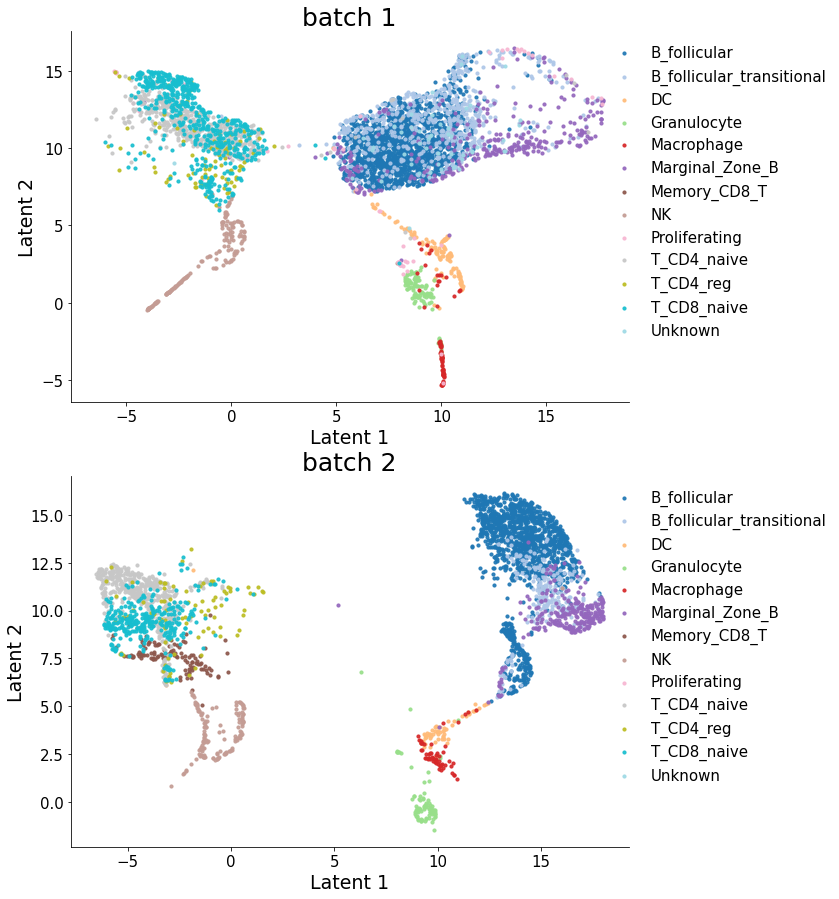

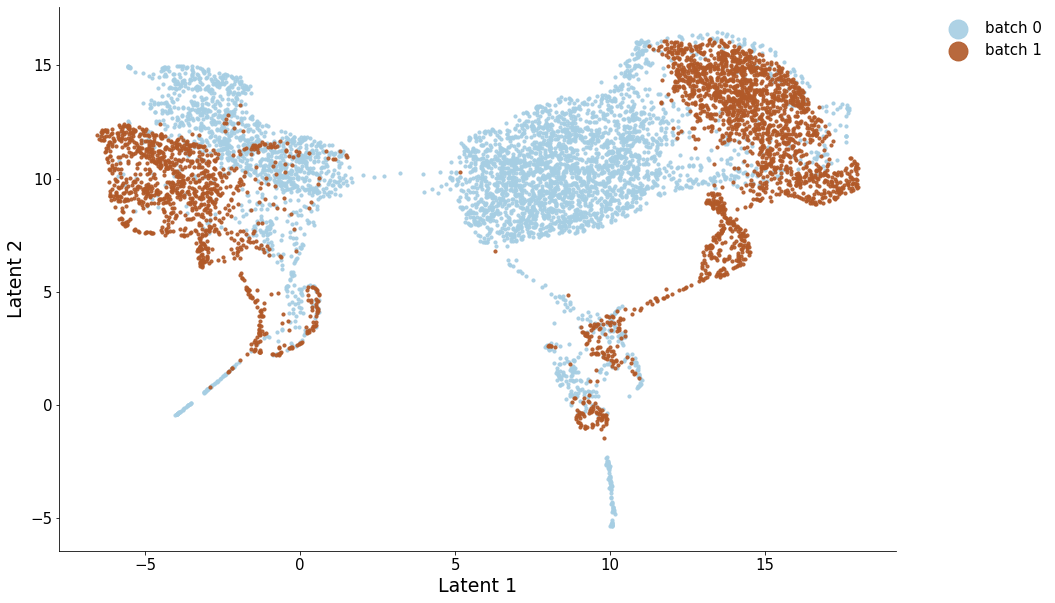

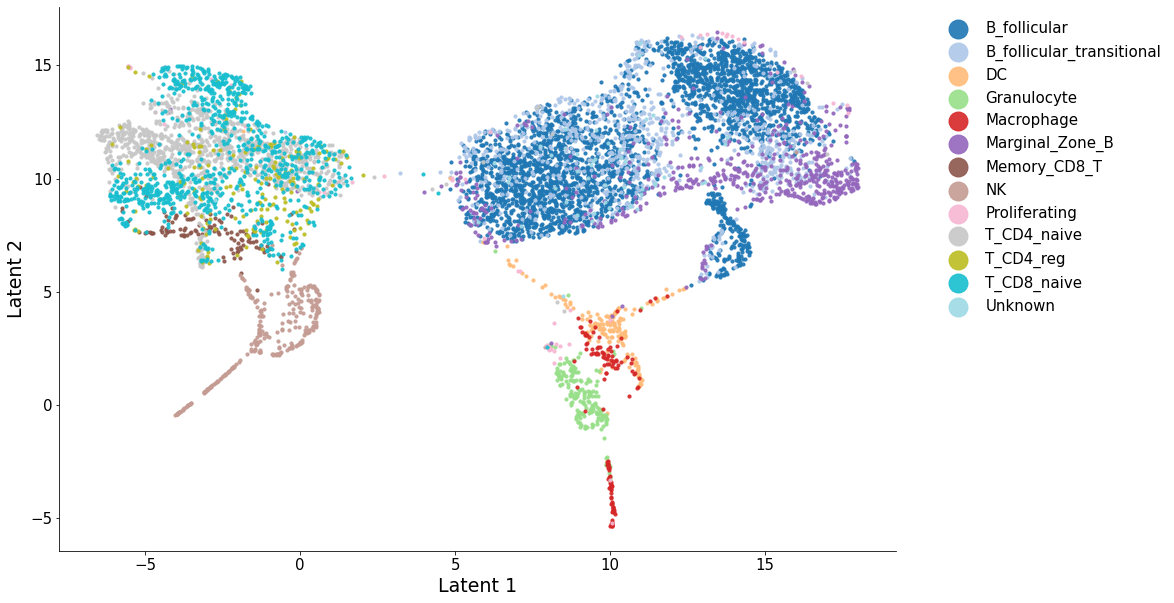

In [24]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (15,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, figsize = (15,10), axis_label = "Latent", markerscale = 6)


../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


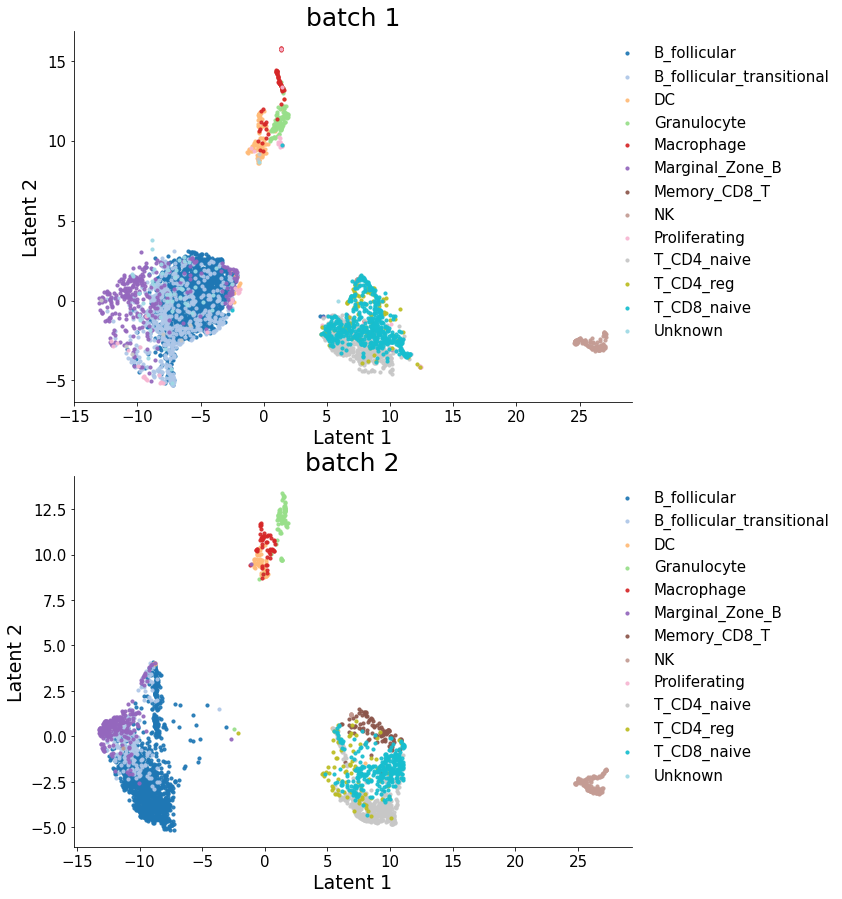

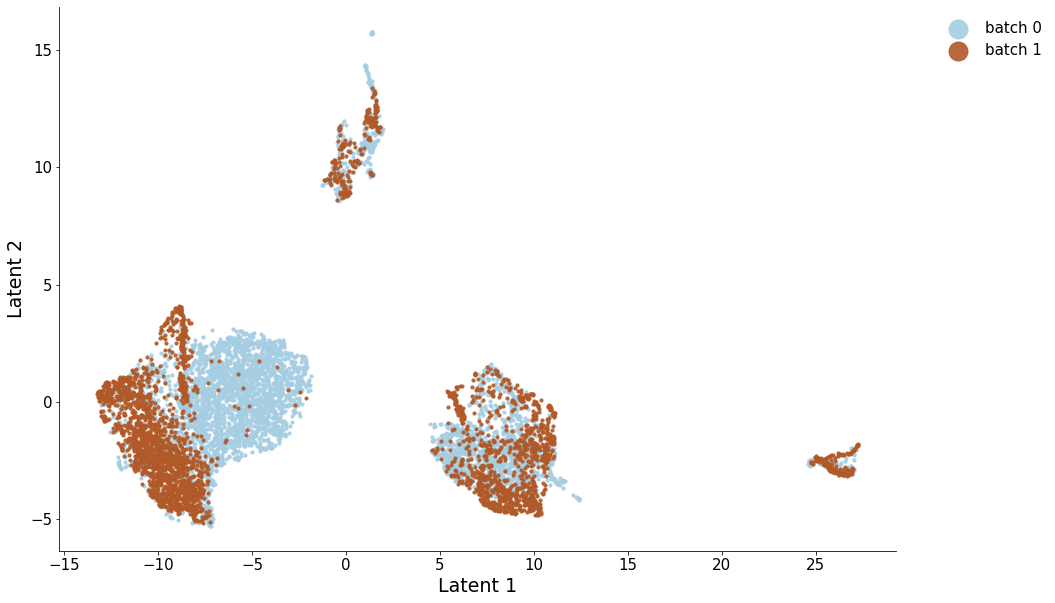

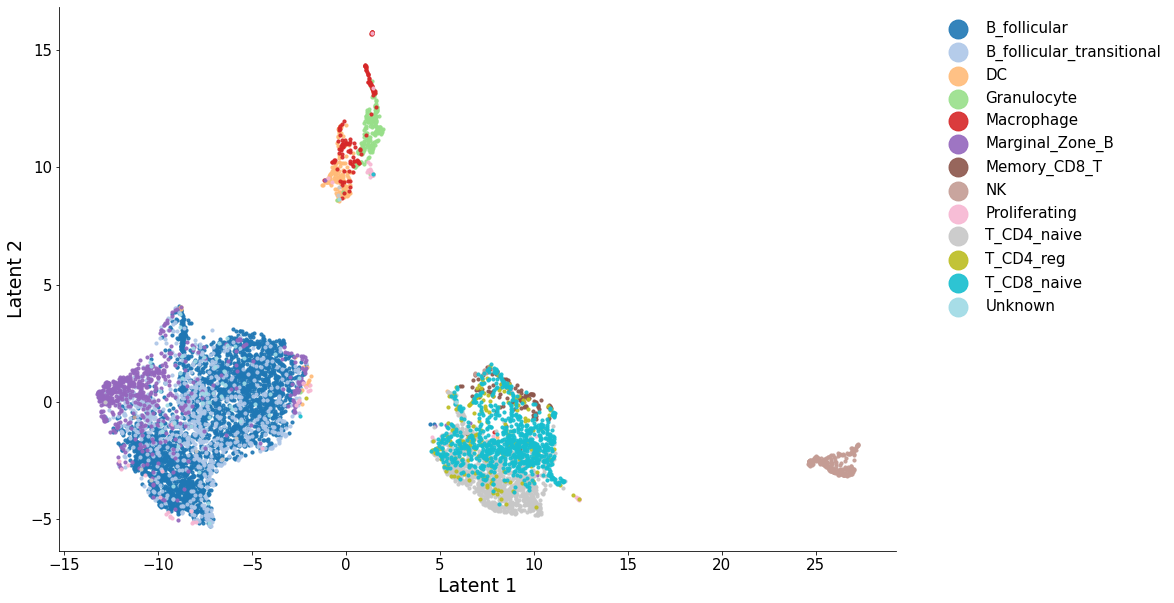

In [25]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, 
                    start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p)
p += p.T - np.diag(p.diagonal())
np.fill_diagonal(p, 0)
s_pair_dist = csr_matrix(p)

# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 12

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)


knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1],
                                 b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (15,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (15,10), axis_label = "Latent", markerscale = 6)



In [76]:
model1.scales

{'rna': tensor([0.4487, 1.2212], device='cuda:0')}

## New model
### Not transform into scRNA-Seq

In [2]:
import importlib
importlib.reload(model_refine)
importlib.reload(utils)

<module 'utils' from '../src/utils.py'>

In [3]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# normalize A
A = utils.preprocess(A, modality = "interaction")
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

In [4]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
K = 30
Ns = [K] * 2
N_feat = Ns[0]
interval = 1000
T = 6000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model_refine.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

Input sanity check...
Finished.
loss1_sub: 9.4575e-03
loss1_sub: 7.3840e-02
Epoch 1000, Validating Loss: 78.4758
	 loss 1: 0.08330
	 loss 2: 0.00056
	 loss 3: -0.96442
loss1_sub: 9.2827e-03
loss1_sub: 7.3230e-02
Epoch 2000, Validating Loss: 77.6742
	 loss 1: 0.08251
	 loss 2: 0.00246
	 loss 3: -0.96811
loss1_sub: 9.1733e-03
loss1_sub: 7.3065e-02
Epoch 3000, Validating Loss: 77.3872
	 loss 1: 0.08224
	 loss 2: 0.00279
	 loss 3: -0.97069
loss1_sub: 9.1055e-03
loss1_sub: 7.2974e-02
Epoch 4000, Validating Loss: 77.2206
	 loss 1: 0.08208
	 loss 2: 0.00216
	 loss 3: -0.97213
loss1_sub: 9.0559e-03
loss1_sub: 7.2909e-02
Epoch 5000, Validating Loss: 77.1022
	 loss 1: 0.08196
	 loss 2: 0.00228
	 loss 3: -0.97292
loss1_sub: 9.0208e-03
loss1_sub: 7.2842e-02
Epoch 6000, Validating Loss: 76.9963
	 loss 1: 0.08186
	 loss 2: 0.00255
	 loss 3: -0.97387
running time: 82.3358781337738


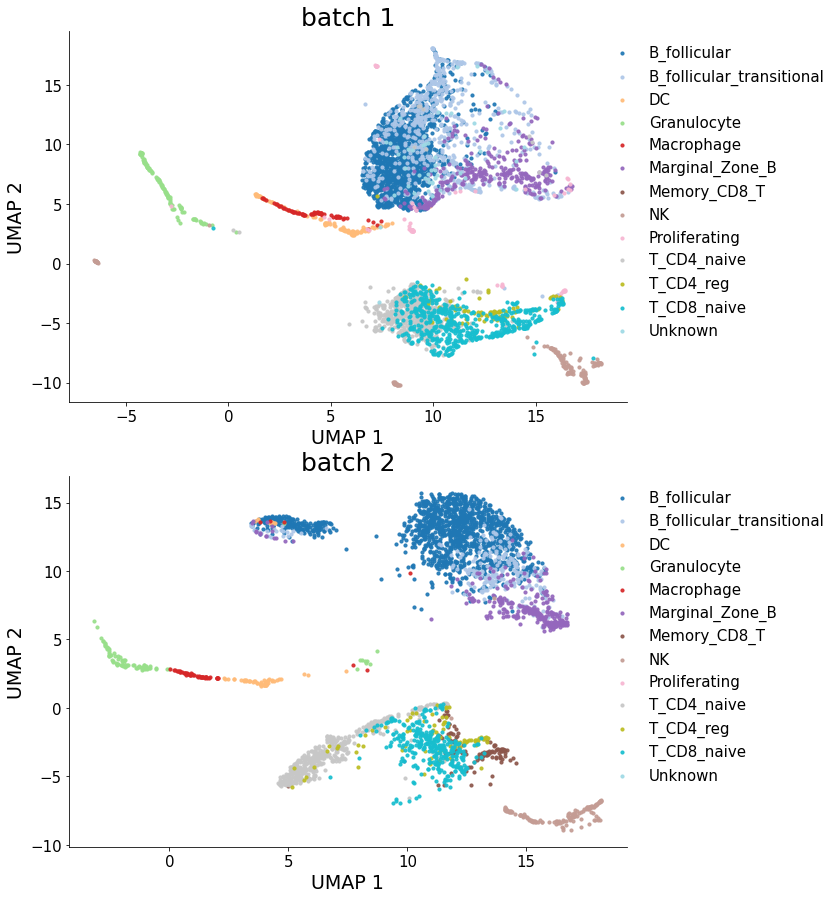

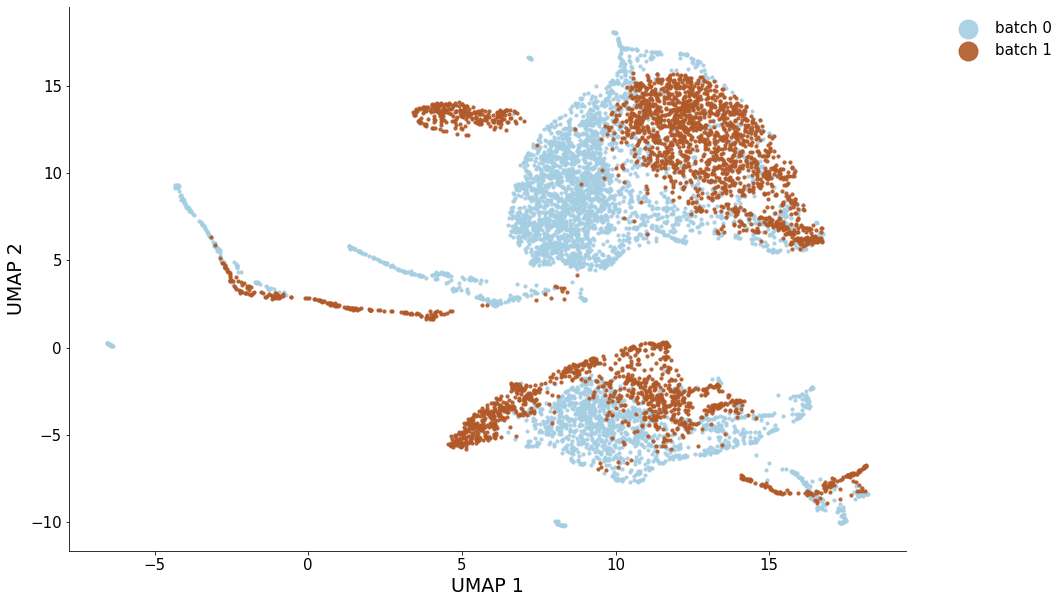

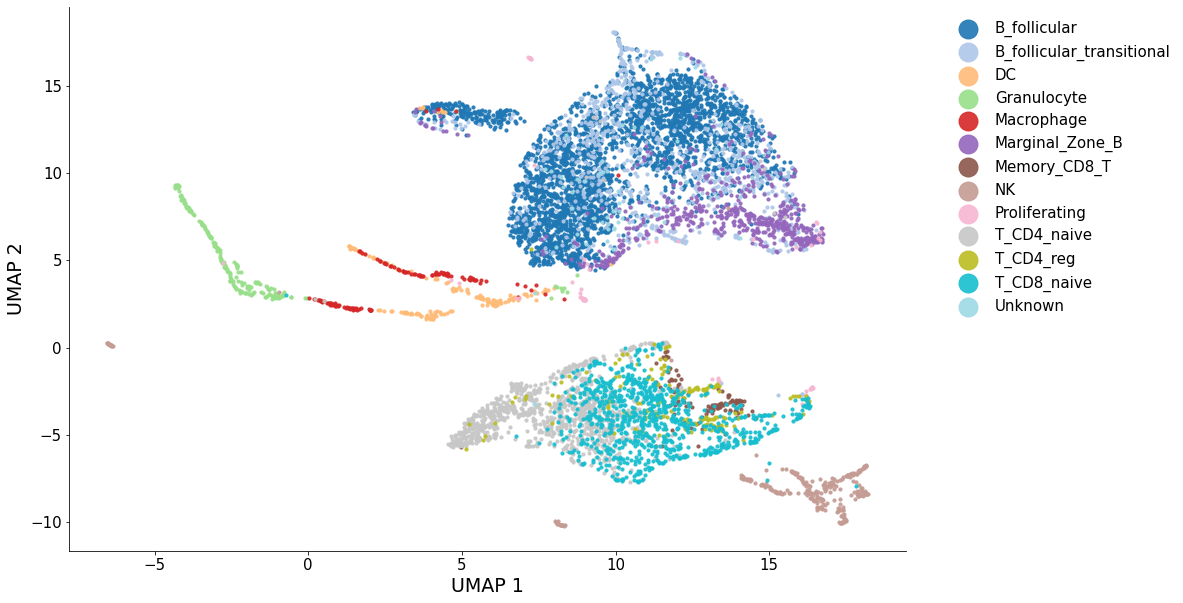

In [5]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "UMAP")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = "Spleen/umap_batches.png", figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = "Spleen/umap_celltype.png", figsize = (15,10), axis_label = "UMAP", markerscale = 6)


## Post-processing-1

In [18]:
# scDART flavor
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
# zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 1)
zs2 = zs

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

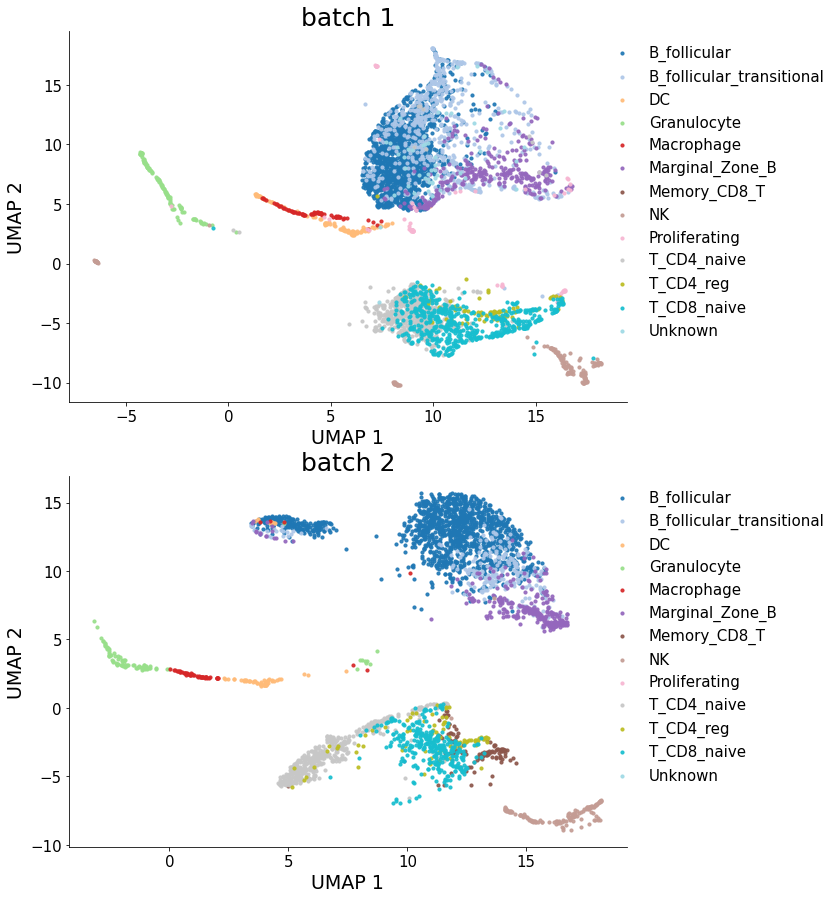

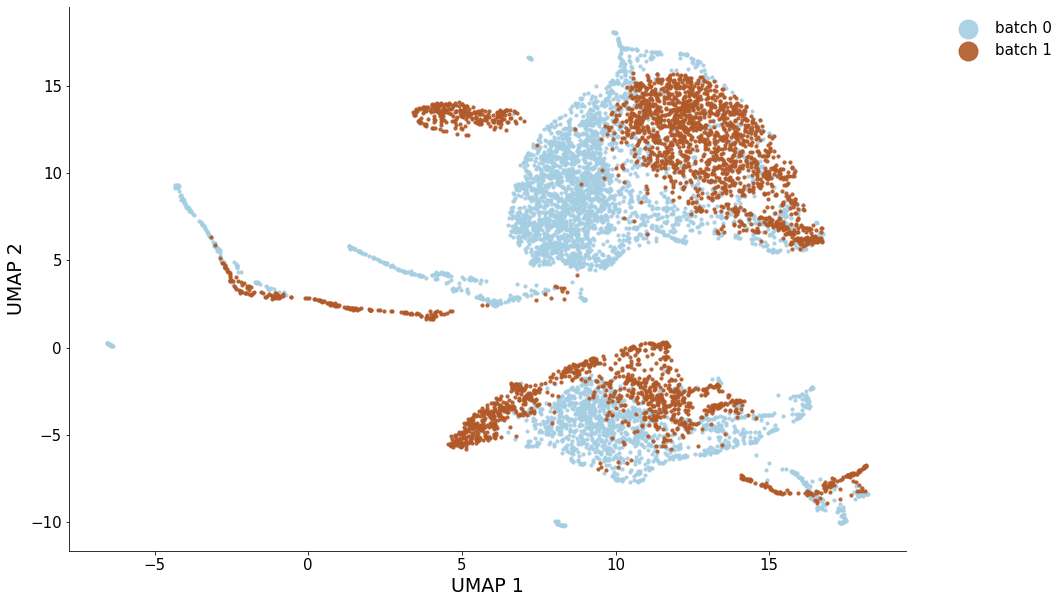

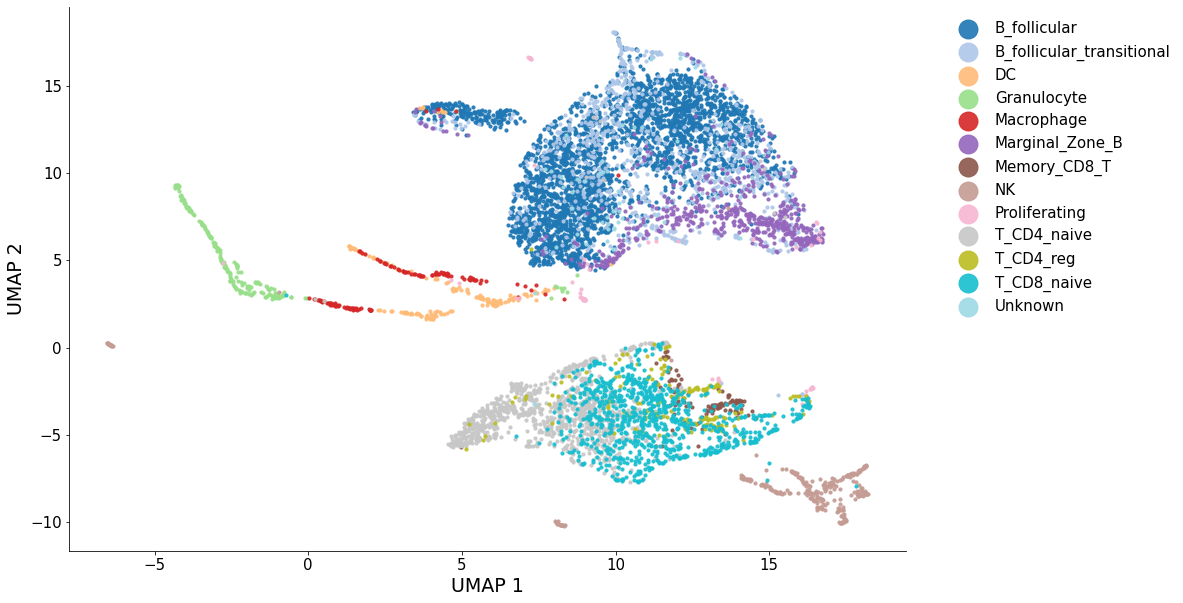

In [19]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "UMAP")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = "Spleen/umap_batches_scdart_post.png", 
                      figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = "Spleen/umap_celltype_scdart_post.png", 
                      figsize = (15,10), axis_label = "UMAP", markerscale = 6)


## Post-processing-2

../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


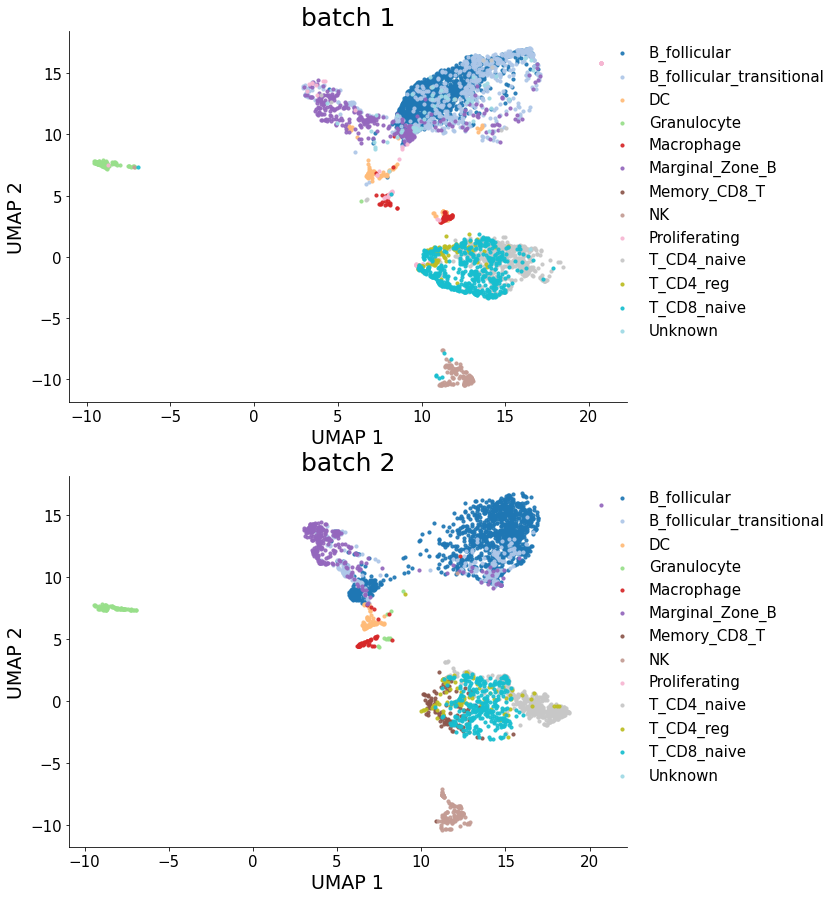

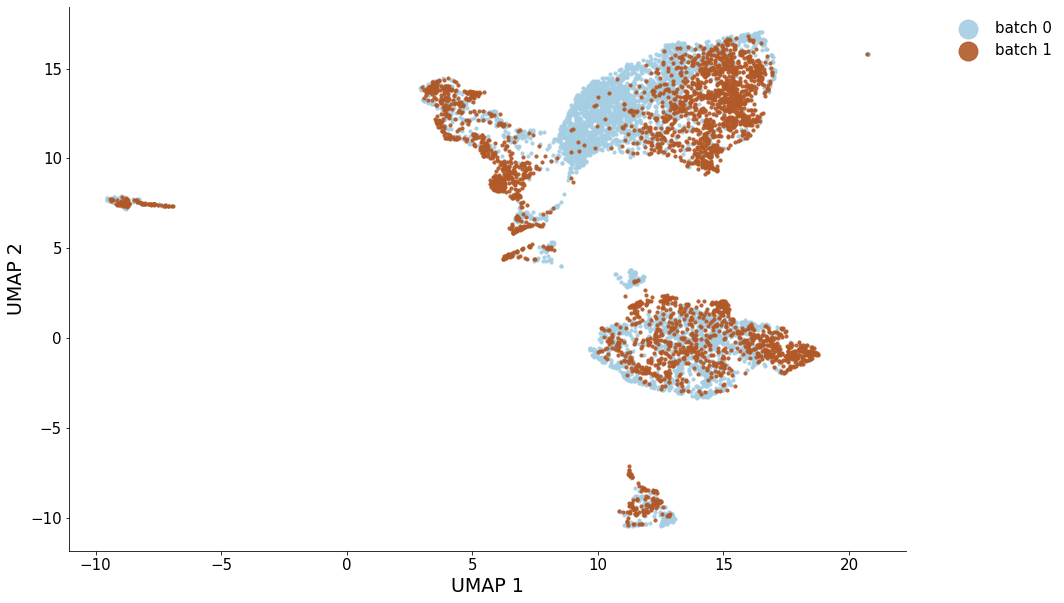

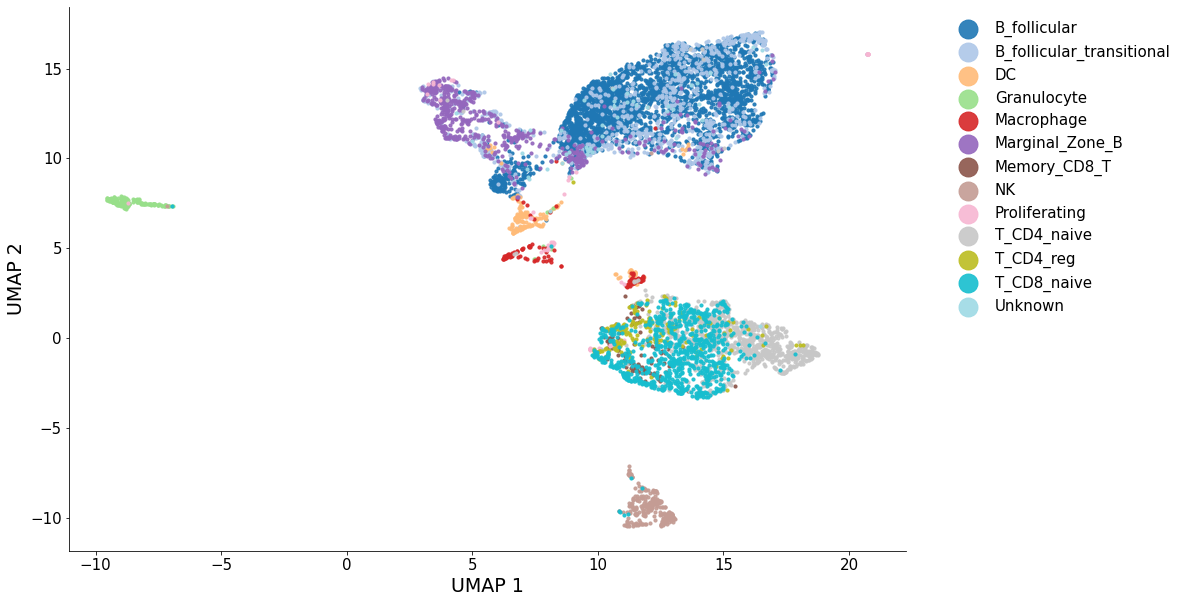

In [6]:
# get a pairwise distance matrix
np.random.seed(0)

pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, 
                    start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p)
p += p.T - np.diag(p.diagonal())
np.fill_diagonal(p, 0)
s_pair_dist = csr_matrix(p)

# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 7

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)


knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1],
                                 b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "UMAP")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = "Spleen/umap_batches_post.png", 
                      figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = "Spleen/umap_celltype_post.png", 
                      figsize = (15,10), axis_label = "UMAP", markerscale = 6)

